# Verifica BCE con pesi per bilanciamento dataset sbilanciato

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, compute_class_weight
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()

import torch

In [2]:
#funzioni per gestire gli array da passare alle loss

def to_tensor_complementare(array):
    v_array = torch.tensor(array, dtype=torch.float32).unsqueeze(1)
    complementare = 1 - v_array # torch.empty([array.shape[0], 1])
    res = torch.cat((v_array, complementare), -1)
    return res      #    res[:,1] = 1 - res[:,0]  

def to_tensor(array):
    v_array = torch.tensor(array, dtype=torch.float32).unsqueeze(1)
    return v_array

def s(array):
    return np.random.permutation(array)

def calc_loss(loss_funx, complementare = False, reduction = False, all_weights=None):    
    # sceglie la funzione per gestire gli array
    if complementare:
        v = to_tensor_complementare
    else:
        v = to_tensor
    loss_zeri = loss_funx(v(y_pred_zeri), v(y_true_shuf))
    loss_uni = loss_funx(v(y_pred_uni), v(y_true_shuf))
    loss_middle = loss_funx(v(y_pred_middle), v(y_true_shuf))
    loss_optimal = loss_funx(v(y_pred_optimal), v(y_true))
    
    
    
    if reduction:
        final_loss_zeri = (loss_zeri * all_weights(y_true_shuf) ).mean()
        final_loss_uni = (loss_uni * all_weights(y_true_shuf) ).mean()
        final_loss_middle = (loss_middle * all_weights(y_true_shuf) ).mean()
        final_loss_optimal = (loss_optimal * all_weights(y_true) ).mean()
        return final_loss_zeri.item(), final_loss_middle.item(), final_loss_uni.item(), final_loss_optimal.item()
        
    else:
        return loss_zeri.item(), loss_middle.item(), loss_uni.item(), loss_optimal.item()
        
    
def print_f(four_losses, suptitle=None):
    loss_zeri, loss_middle, loss_uni, loss_optimal = four_losses
    just = 6
    fig, ax = plt.subplots(1,4, figsize=(30,6))
    
    ax[0].hist((y_true, y_pred_zeri), bins=50);
    ax[0].set_title(f"Mod comunista {str(round(loss_zeri, 5))}")
    
    ax[1].hist((y_true, y_pred_uni), bins=50);
    ax[1].set_title(f"Mod fascista {str(round(loss_uni, 5))}")
    
    ax[2].hist((y_true, y_pred_middle), bins=50);
    ax[2].set_title(f"Mod di centro {str(round(loss_middle, 5))}")
    
    ax[3].hist((y_true, y_pred_optimal), bins=50);
    ax[3].set_title(f"Mod Utòpia {str(round(loss_optimal, 5))}")
    
    fig.suptitle(suptitle)
    
    ##print(f"Zeri: {str(round(loss_zeri, 5)).ljust(just, ' ')} \
    ##          Centro: {str(round(loss_middle, 5)).ljust(just, ' ')} \
    ##          Uni: {str(round(loss_uni, 5)).ljust(just, ' ')} \
    ##          Ottimale: {str(round(loss_optimal, 5)).ljust(just, ' ')}")
    


### valori veri e predetti

In [10]:
#y_true = np.array([1  , 1  , 1   , 0   , 0   , 0   , 0   , 0   , 0  , 0  , 0  , 0  , 0  ])
y_true = np.array([1]*50 + [0]*950)
y_true_shuf = s(y_true)

sigma = 0.08
#y_pred = np.array([0.4, 0.4, 0.4, 0.35, 0.28, 0.45, 0.25, 0.45, 0.1, 0.1, 0.1, 0.1, 0.2])
y_pred_zeri = np.random.normal(0.2,sigma,1000)
#y_pred2 = np.array([0.99, 0.99, 0.99, 0.05, 0.02, 0.05, 0.025, 0.045, 0.1, 0.1, 0.1, 0.1, 0.02])
y_pred_uni = np.random.normal(0.8,sigma,1000)
y_pred_middle = np.random.normal(0.5,sigma,1000)
y_pred_optimal = np.concatenate(( np.random.normal(0.8,sigma,50) , np.random.normal(0.2,sigma,950) )) 

y_true3 = np.array([1,1,0])
y3 = np.array([4, 4, -4])

y_true_balanced = np.array([1]*500 + [0]*500)
y_true_balanced_shuf = s(y_true_balanced)

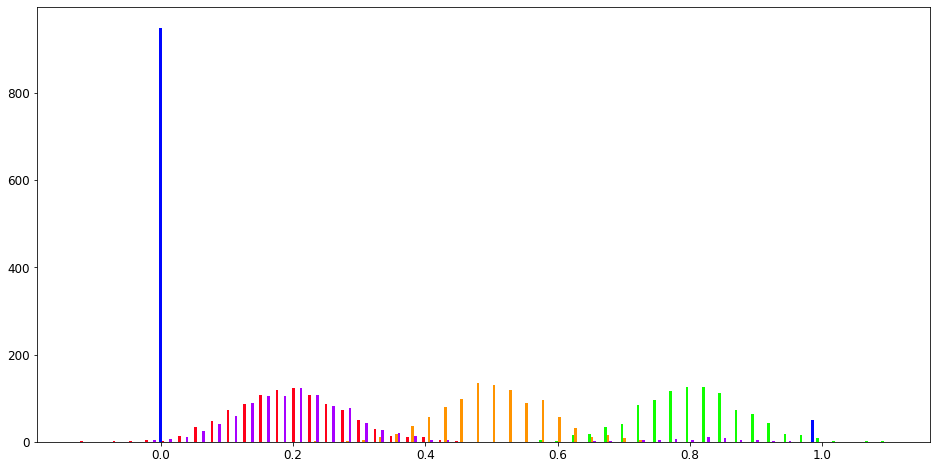

In [4]:
plt.hist((y_true, y_pred_zeri, y_pred_uni, y_pred_middle, y_pred_optimal), bins=50);

In [5]:
num_uni = y_true.sum()
tot = len(y_true)
num_zeri = (tot-num_uni)
p_zeri = (num_zeri)/tot
p_uni = num_uni/tot
#print(tot/(tot-uni), tot/uni)

print(num_zeri, num_uni)

950 50


In [5]:
criterion = torch.nn.BCEWithLogitsLoss() ##reduction='sum')

peso = num_zeri/num_uni
mono_weight = torch.tensor(peso, dtype=torch.float32)
criterion_mono = torch.nn.BCEWithLogitsLoss(pos_weight=mono_weight) ##, reduction='sum')

due_pesi = [num_zeri, num_uni]  ##[p_zeri,p_uni]
custom_weights = torch.tensor(due_pesi, dtype=torch.float32)
criterion_2 =  torch.nn.BCEWithLogitsLoss(pos_weight=custom_weights) ##, reduction='sum')

NameError: name 'num_zeri' is not defined

## Calcolo le loss

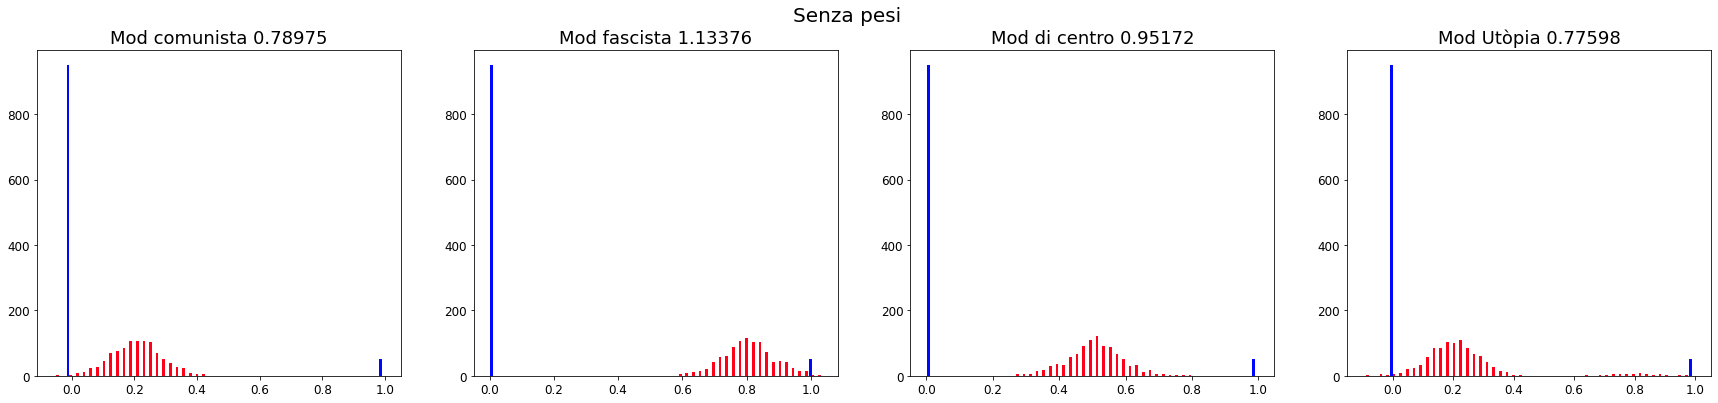

In [11]:
print_f(calc_loss(criterion, complementare=False), suptitle="Senza pesi")

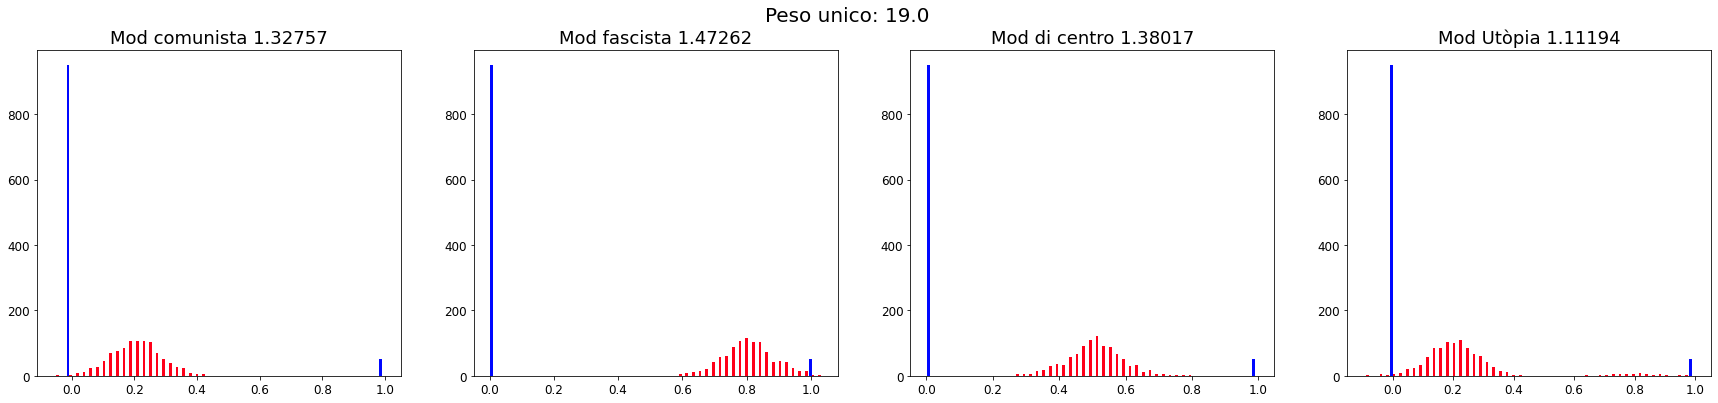

In [12]:
print_f(calc_loss(criterion_mono, complementare=False), suptitle=f"Peso unico: {peso}")

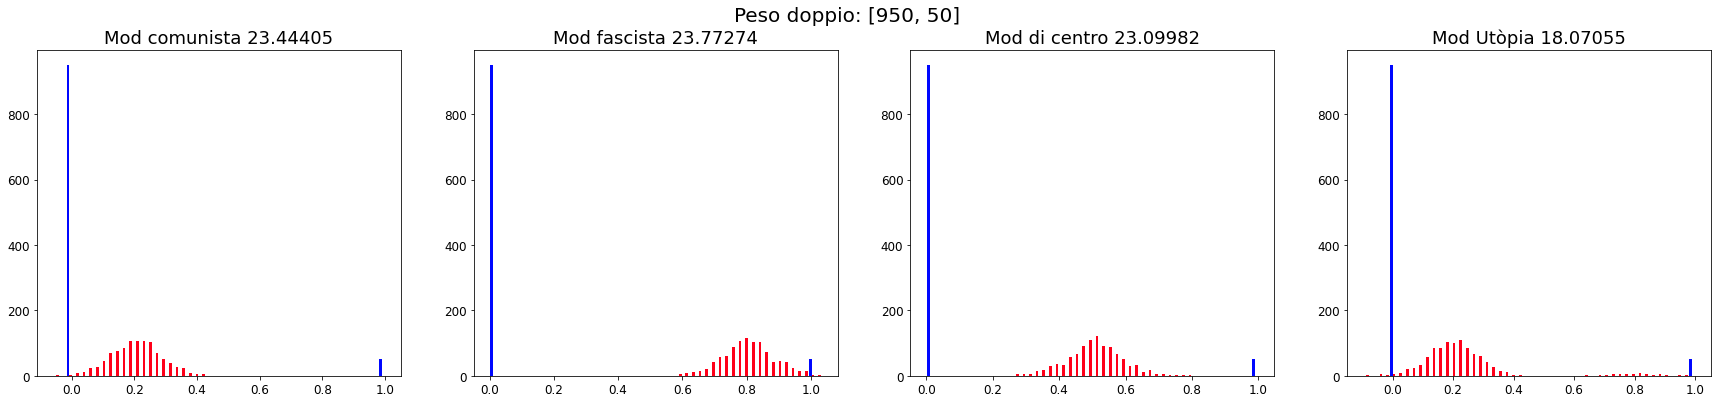

In [13]:
print_f(calc_loss(criterion_2, complementare=True), suptitle=f"Peso doppio: {due_pesi}")

In [14]:
def get_losses_no_weights(mu):
    y_pred = np.random.normal(mu, 0.5, 1000) 
    criterion = torch.nn.BCEWithLogitsLoss()  ##pos_weight=mono_weight)
    #print(f"pesi: {mono_weight.item()}")
    loss = criterion(to_tensor(y_pred), to_tensor(y_true_shuf))
    return (loss.item())

def get_losses_balanced(mu, sigma=0.5):
    y_pred = np.random.normal(mu, sigma, 1000) 
    criterion = torch.nn.BCEWithLogitsLoss()  ##pos_weight=mono_weight)
    #print(f"pesi: {mono_weight.item()}")
    loss = criterion(to_tensor(y_pred), to_tensor(y_true_balanced_shuf))
    return (loss.item())

def get_losses_mono(mu, value, sigma):
    y_pred = np.random.normal(mu, sigma, 1000) 
    mono_weight = torch.tensor(value, dtype=torch.float32)
    criterion_mono = torch.nn.BCEWithLogitsLoss(pos_weight=mono_weight)
    #print(f"pesi: {mono_weight.item()}")
    loss = criterion_mono(to_tensor(y_pred), to_tensor(y_true_shuf))
    return (loss.item())

def get_losses_bi(mu, biweights, sigma):
    y_pred = np.random.normal(mu, sigma, 1000)
    custom_w = torch.tensor(biweights, dtype=torch.float32)
    criterion_bi = torch.nn.BCEWithLogitsLoss(pos_weight=custom_w)
    #print(f"pesi: {mono_weight.item()}")
    loss = criterion_bi(to_tensor_complementare(y_pred), to_tensor_complementare(y_true_shuf))
    return (loss.item())

def plot_losses_w_mu_weight(loss_f, p_array, sigma):
    xs = np.arange(0, 1, 0.001)
    ##p_array = range(23, 38, 1)
    ##p_array = np.arange(0, 5, 0.1)
    cols = 7
    rows = len(p_array) // cols + len(p_array)%cols
    fig, ax = plt.subplots(rows,cols, figsize=(30,20))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(p_array):
                p = p_array[idx]
                losses_mu = [loss_f(mu, p, sigma) for mu in xs]
                ax[i][j].scatter(xs, losses_mu)
                ax[i][j].set_title(p)
    plt.show()

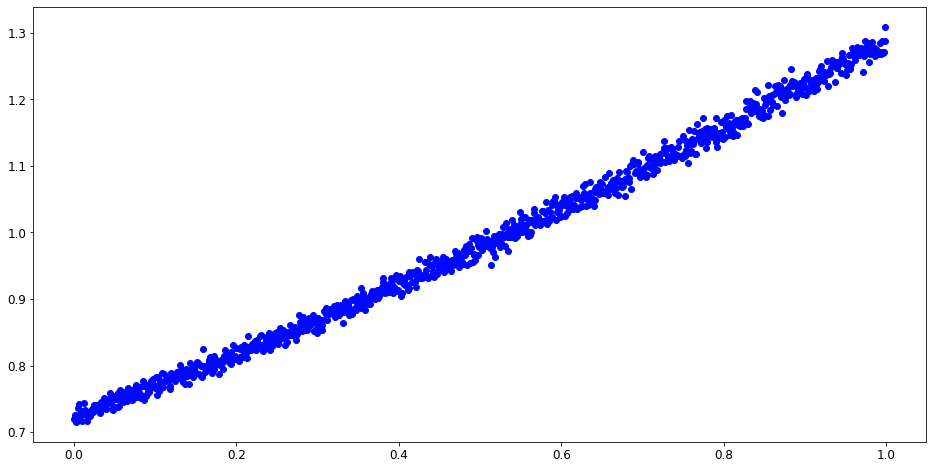

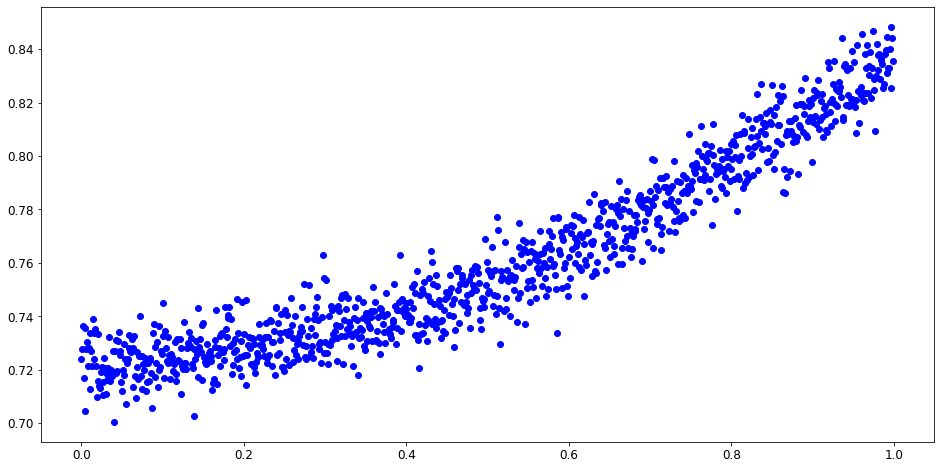

In [15]:
xs = np.arange(0, 1, 0.001)
losses_mu = [get_losses_no_weights(mu) for mu in xs]
plt.scatter(xs, losses_mu)
plt.show()




xs = np.arange(0, 1, 0.001)
losses_mu = [get_losses_balanced(mu) for mu in xs]
plt.scatter(xs, losses_mu)
plt.show()



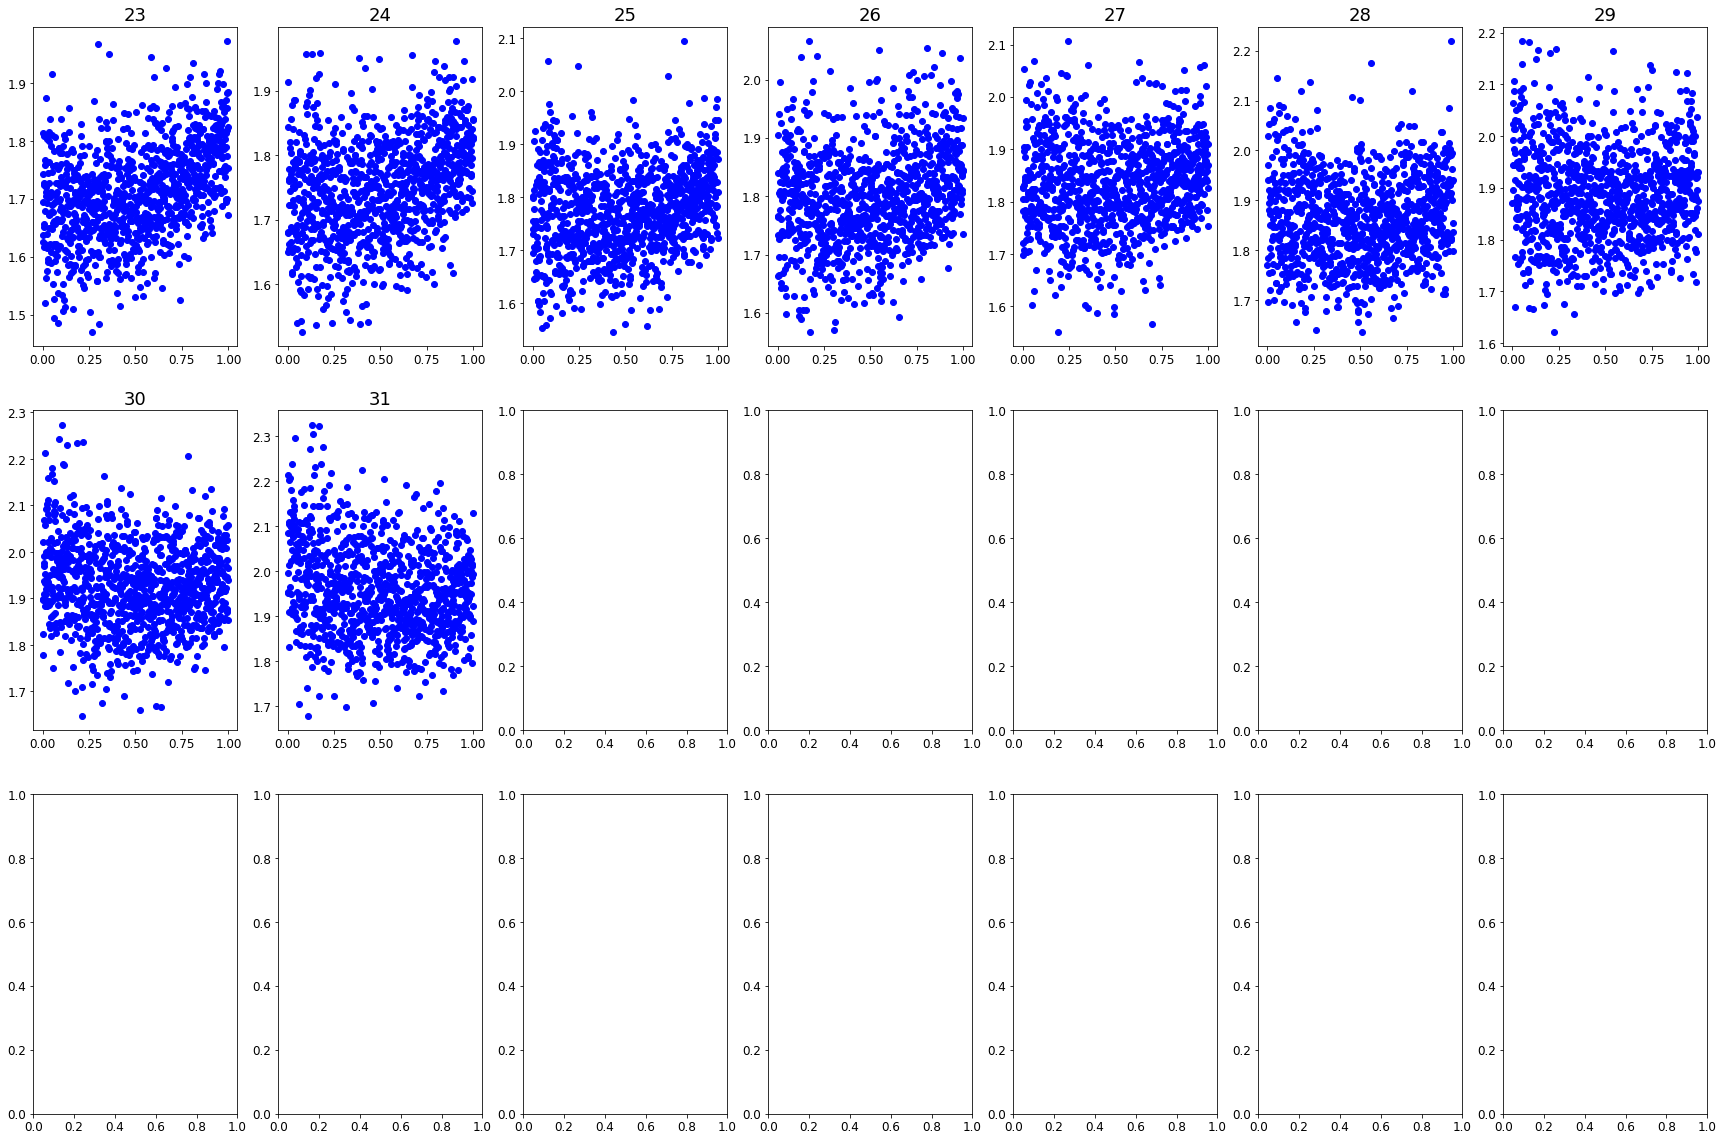

In [117]:
p_array = range(23, 32, 1)
plot_losses_w_mu_weight(get_losses_mono, p_array, sigma=1.0)

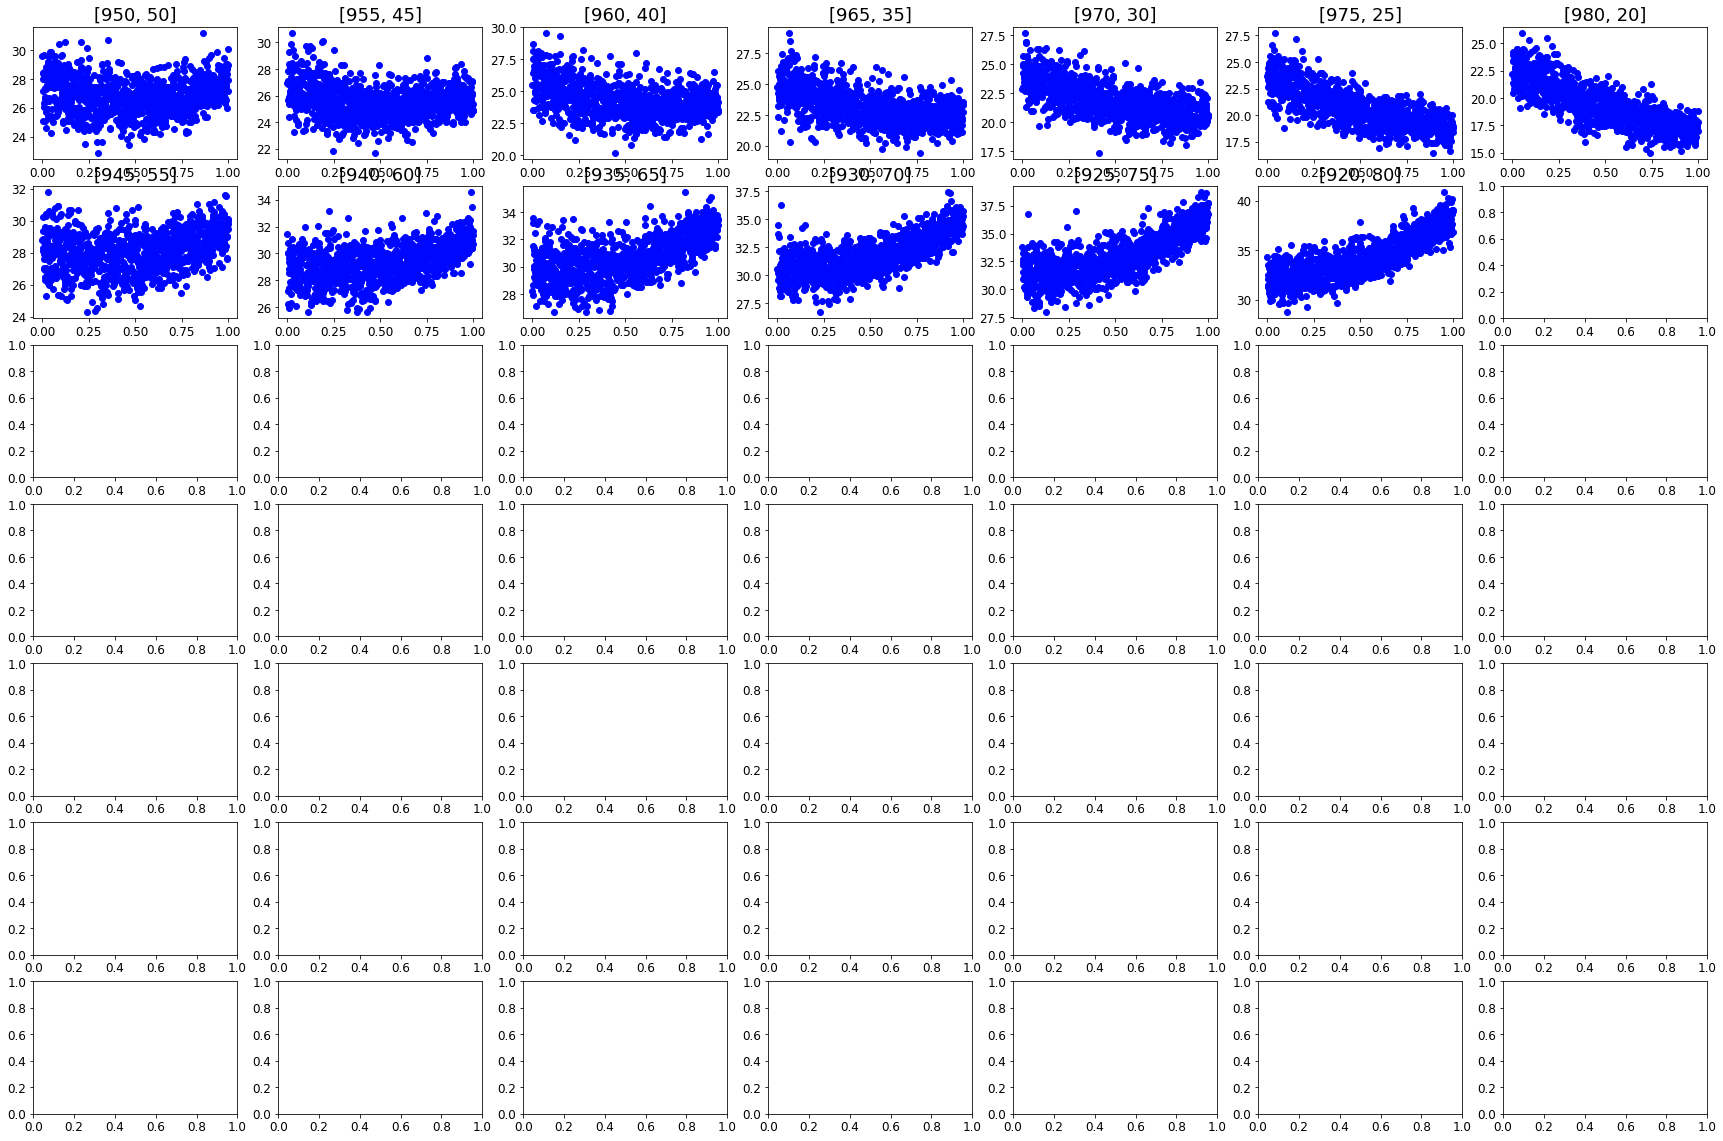

In [138]:
p_array = [[num_zeri, num_uni],[955, 45], [960, 40],[965, 35],[970, 30],[975, 25],[980, 20],[945, 55],[940, 60],[935, 65],[930, 70],[925, 75],[920, 80]]
losses = plot_losses_w_mu_weight(get_losses_bi, p_array, sigma=0.8)

# calcolo loss separata

In [55]:
y_true_uni = y_true[:50]
y_true_zeri = y_true[50:]
y_pred_middle_1 = y_pred_middle[:50]
y_pred_middle_2 = y_pred_middle[50:]

y_true3_uni = y_true3[:2]
y_pred3_uni = y3[:2]
y_true3_zeri = y_true3[2]
y_pred3_zeri = y3[2]
y_true3_uni, y_pred3_uni, y_true3_zeri, y_pred3_zeri



(array([1, 1]), array([4, 4]), 0, -4)

In [56]:
criterion(to_tensor(y_pred3_uni), to_tensor(y_true3_uni)).item()

0.036299921572208405

In [57]:
criterion(torch.tensor(y_pred3_zeri, dtype=torch.float32 ), torch.tensor(y_true3_zeri, dtype=torch.float32)).item()

0.018149960786104202

In [58]:
# loss bilanciata
peso = 1/2.0
mono_weight = torch.tensor(peso, dtype=torch.float32)
criterion_mono3 = torch.nn.BCEWithLogitsLoss(pos_weight=mono_weight, reduction='sum')


criterion_mono3(to_tensor(y_pred3_uni), to_tensor(y_true3_uni)).item() 

0.018149960786104202

In [59]:
criterion_mono3(torch.tensor(y_pred3_zeri, dtype=torch.float32), torch.tensor(y_true3_zeri, dtype=torch.float32)).item()

0.018149852752685547

In [60]:
-np.log(torch.sigmoid(torch.tensor(4)))

tensor(0.0181)

In [75]:
losspiu_nb = criterion(to_tensor(y_pred_middle_1), to_tensor(y_true_uni)).item()
losspiu_nb

23.607831954956055

In [76]:
losspiu = losspiu_nb * peso
losspiu

448.54880714416504

In [77]:
lossmeno_nb = criterion(to_tensor(y_pred_middle_2), to_tensor(y_true_zeri)).item()

In [78]:
lossmeno_nb

925.0897216796875

In [79]:
# loss bilanciata
criterion_mono(to_tensor(y_pred_middle_1), to_tensor(y_true_uni)).item()

448.548828125

In [80]:
criterion_mono(to_tensor(y_pred_middle_2), to_tensor(y_true_zeri)).item()

925.0897216796875

# Loss Esempio 5-7-23

In [47]:
y_true0 = to_tensor(np.array([1]*50 + [0]*50))
y_true1 = to_tensor(np.array([1]*5 + [0]*95))

y_pred0 = to_tensor(np.array([4]*50 + [-4]*50))
y_pred1 = to_tensor(np.array([4]*100))
y_pred2 = to_tensor(np.array([-4]*100))


criterion = torch.nn.BCEWithLogitsLoss()

print(torch.sigmoid(torch.tensor(4,dtype=torch.float32)))
print(torch.sigmoid(torch.tensor(-4,dtype=torch.float32)))
criterion(torch.tensor(1,dtype=torch.float32),torch.tensor(4,dtype=torch.float32))

tensor(0.9820)
tensor(0.0180)


tensor(-2.6867)

### Loss è simmetrica quando il dataset è bilanciato

In [37]:
print(criterion(y_pred0, y_true0).item())
print(criterion(y_pred1, y_true0).item())
print(criterion(y_pred2, y_true0).item())

0.018149960786104202
2.0181500911712646
2.0181500911712646


### Dataset sbilanciato

In [38]:
print(criterion(y_pred0, y_true1).item())
print(criterion(y_pred1, y_true1).item())
print(criterion(y_pred2, y_true1).item())

1.8181499242782593
3.818150043487549
0.21815000474452972


### Dataset sbilanciato con loss pesata

In [50]:
peso = torch.tensor(95/5.0,dtype=torch.float32)
print(peso)
criterion_pesato = torch.nn.BCEWithLogitsLoss(pos_weight=peso)

tensor(19.)


In [48]:
print(criterion_pesato(y_pred0, y_true1).item())
print(criterion_pesato(y_pred1, y_true1).item())
print(criterion_pesato(y_pred2, y_true1).item())

1.8344848155975342
3.834484815597534
3.8344850540161133


### Dataset sbilanciato con loss non pesata ma peso moltiplicato dopo 

In [68]:
criterion_nonridotto = torch.nn.BCEWithLogitsLoss(reduction='none')
def all_weights2(custom_w, y_true):
    diz = {c:w for c, w in enumerate(custom_w)}
    return torch.tensor([diz[y] for y in y_true])

array_pesi1 = all_weights2([1,19], y_true1.squeeze().tolist())
array_pesi1

tensor([19, 19, 19, 19, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [99]:
{c:w for c, w in enumerate([1,19])}

{0: 1, 1: 19}

In [98]:
(res0*array_pesi1)[:6,:6]##.squeeze()##*array_pesi1

tensor([[3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 1.8150e-02],
        [3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 1.8150e-02],
        [3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 1.8150e-02],
        [3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 1.8150e-02],
        [3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 3.4485e-01, 1.8150e-02],
        [7.6345e+01, 7.6345e+01, 7.6345e+01, 7.6345e+01, 7.6345e+01, 4.0181e+00]])

tensor([0.0181, 4.0181])
34544.8515625
183.439


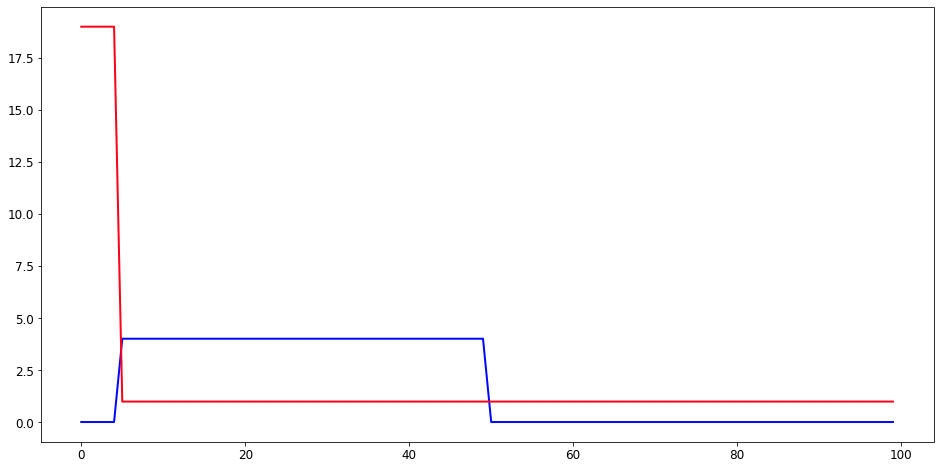

tensor([0.0181, 4.0181])
383.448486328125
383.43899999999996


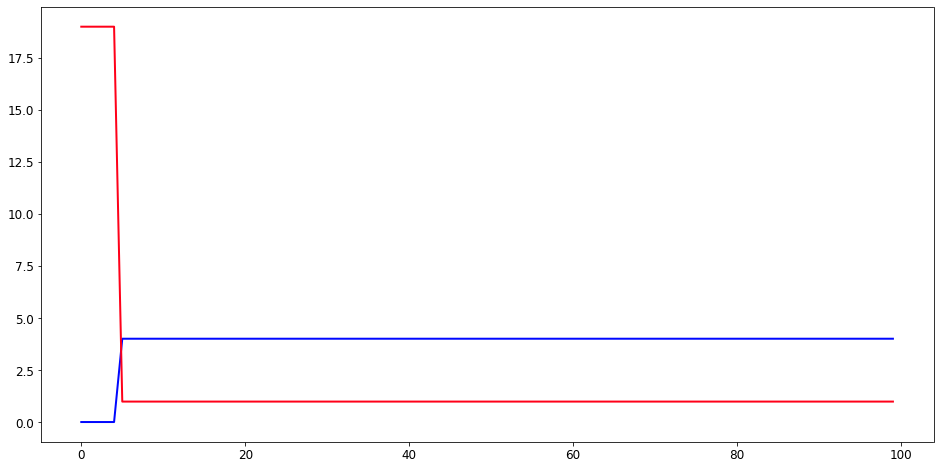

tensor([0.0181, 4.0181])
383.4485168457031
383.43899999999996


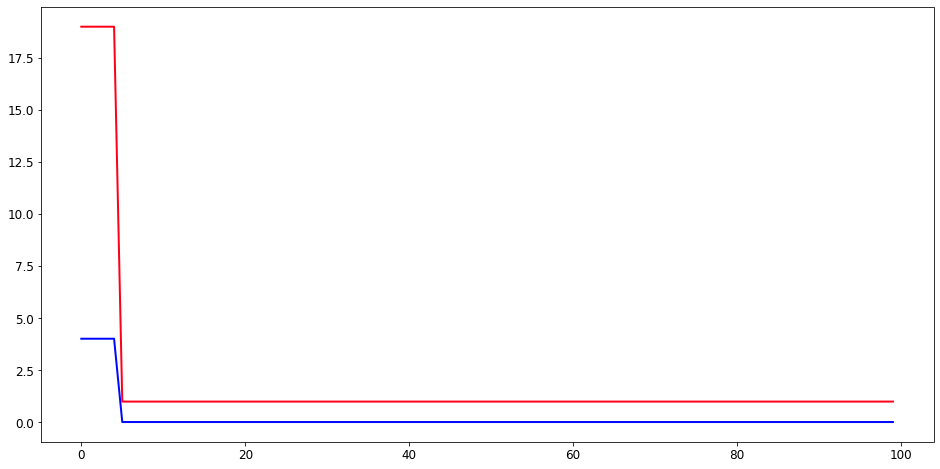

In [88]:
res0 = criterion_nonridotto(y_pred0, y_true1)
plt.plot(res0)
plt.plot(array_pesi1)
print(res0.unique())
print((res0.squeeze()*array_pesi1).sum().item())
print((19*0.0181*5 + 1*4.0181*45 + 1*0.0181*50))
plt.show()
res1 = criterion_nonridotto(y_pred1, y_true1)
plt.plot(res1)
plt.plot(array_pesi1)
print(res1.unique())
print((res1.squeeze()*array_pesi1).sum().item())
print((19*0.0181*5 + 1*4.0181*95))
plt.show()
res2 = criterion_nonridotto(y_pred2, y_true1)
plt.plot(res2)
plt.plot(array_pesi1)
print(res2.unique())
print((res2.squeeze()*array_pesi1).sum().item())
print((19*0.0181*5 + 1*4.0181*95))
plt.show()